# Final Project - Study of the Fashion MNIST Data Set

Neil Chen

2025-02-24

In this project, I'm going to explore the `Fashion MNIST` data set with Unsupervised Learning as well as Supervised Learning methods.

The `Fashion MNIST` is a data set for image recognition tasks. It consists of 60,000 training samples and 10,000 test data.
Each example is a 28x28 grayscale image.

See: <https://www.kaggle.com/datasets/zalando-research/fashionmnist> for more details of the data set.

In [1]:
# I'll put the import statements for all used packages on top of the file
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

## 1. Data Loading and Exploratory Data Analysis (EDA)

### Exploring the train data set

In [2]:
train = pd.read_csv('./data/fashion-mnist_train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [60]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Split the x and y data for unsupervised learning
y_train = train['label']
X_train = train[train.columns.drop(['label'])]
# X_train.head()
# y_train.head()

# Now we will find the max and min color value of all pixels
print('max color value:', np.max(X_train.to_numpy()))
print('min color value:', np.min(X_train.to_numpy()))

max color value: 255
min color value: 0


Based on this finding, we will pre-process the data, by normalizing it to 1-scaled.

In [62]:
X_train_normalized = X_train / 255.0

### Check the test data set

In [63]:
test = pd.read_csv('./data/fashion-mnist_test.csv')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [64]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
y_test = test['label']
X_test = test[test.columns.drop(['label'])]

### Since it's an image data set, we can show some examples of the data by visualization.

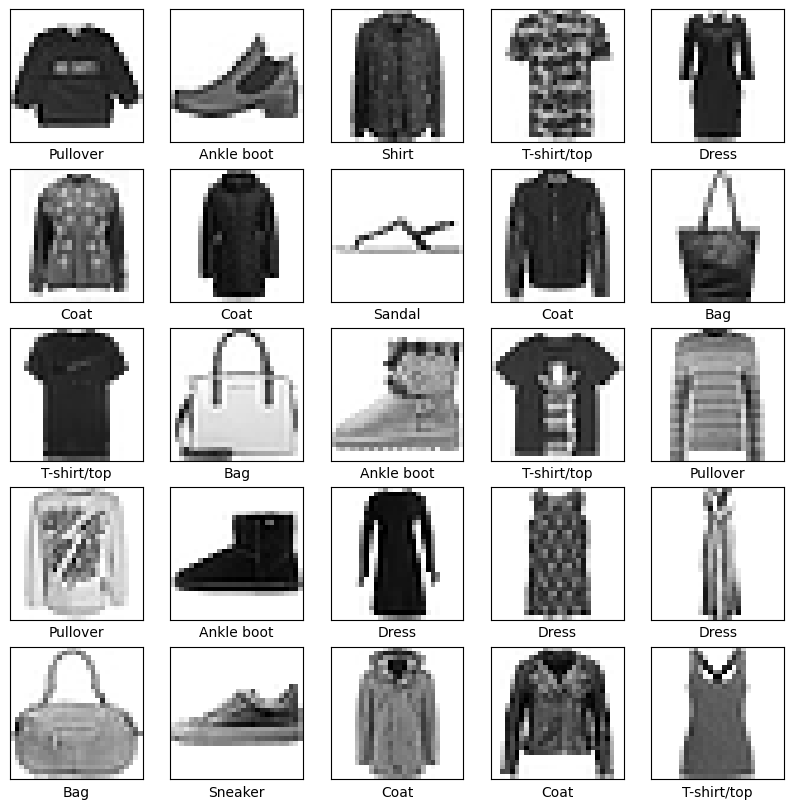

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train_reshaped = X_train.to_numpy().reshape(-1, 28, 28)

# Take 25 examples
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_reshaped[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

### Check the pixel value distribution.

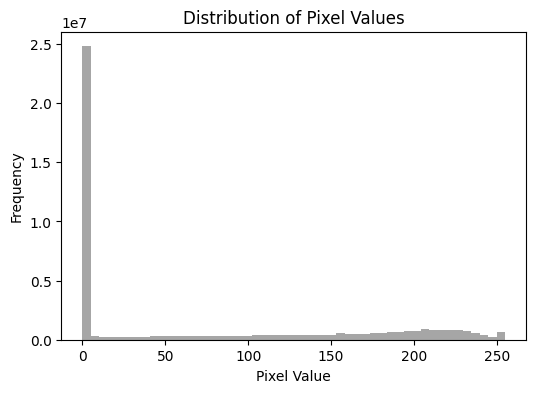

In [121]:
plt.figure(figsize=(6,4))
plt.hist(X_train.to_numpy().flatten(), bins=50, color='gray', alpha=0.7)
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.title("Distribution of Pixel Values")
plt.show()

The visulization shows that the image has many white pixels, which are backgrounds. And for the rest part of the image, other pixel values are quite evenly distributed (not too bright or too dark), so no further processing is needed.

### Generate mean images of each class, which helps us understand what are the representative features of each class.

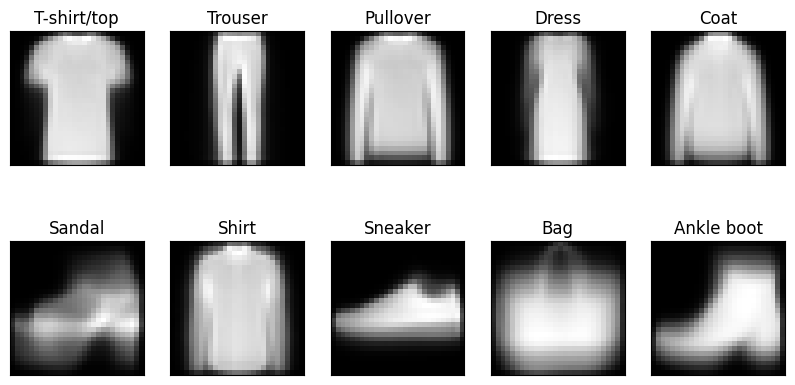

In [ ]:
mean_images = np.zeros((10, 784))

for i in range(10):
    mean_images[i] = np.mean(X_train[y_train == i], axis=0)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(mean_images[i].reshape(28, 28, -1), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(class_names[i])
plt.show()

## 2. Model Training

### Use PCA for dimension reduction

Explained variance ratio by the first 10 PCAs:
[0.29011353 0.17727668 0.060227   0.04970272 0.03839289 0.03470997
 0.02344044 0.01913937 0.01343605 0.01310725]


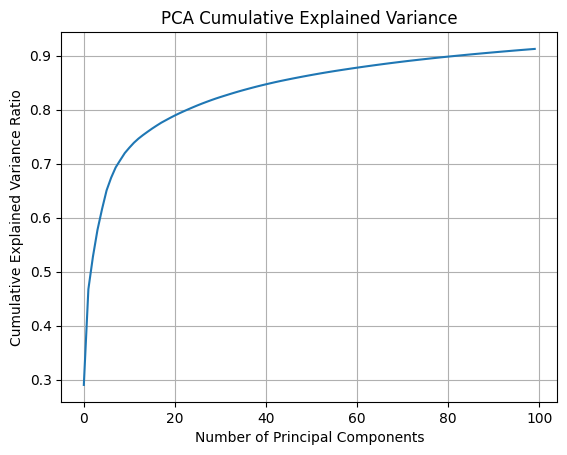

Cumulative explained variance ratio by the first 100 principal components: 
0.91231009624316


In [113]:
pca = PCA(n_components=100)
# Transformed train data with reduced dimensionality
X_train_pca = pca.fit_transform(X_train_normalized)

print('Explained variance ratio by the first 10 PCAs:')
print(pca.explained_variance_ratio_[:10])

# Plot the cumulative explained variance ratios
cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_var_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True)
plt.show()

print('Cumulative explained variance ratio by the first 100 principal components: ')
print(cum_var_ratio[99])

## Use K-Means for clustering

In [66]:
# We use n_clusters = 10 because we know there are 10 different labels
kmeans = KMeans(n_clusters=10, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
print(train_clusters)

[2 3 9 ... 0 0 1]


In [67]:
conf_matrix = confusion_matrix(y_train, train_clusters)
print(conf_matrix)

[[  26    2   26    0  481   83  636 3028 1594  124]
 [   0    0    3    0  119 5245  409    8  153   63]
 [  24    1   26    0  411    8  118   43 1838 3531]
 [   7    0    6    1  428 2308 2494   68  616   72]
 [  30    0   15    0  212   70  980    6 1005 3682]
 [  15 1427   10  482 4025    0    3    0   37    1]
 [  20    6   61    1  614   28  496  647 2125 2002]
 [   0 5104    6  291  599    0    0    0    0    0]
 [2432  283 2194    6  423   15   39    8  322  278]
 [   2  673    5 5053  192    1   12    1   52    9]]


We can see that it has strong diagonal presence for some classes, while for certain classes, it has some misclassifications
(see row 2 and row 4).

Now let's map the clustered labels to real labels.

In [69]:
# Find the most probable real label for each predicted label
def map_real_label(conf_matrix, pred_labels):
    pred_to_real_map = {}
    # iterate each label
    for pred_label in range(conf_matrix.shape[1]):
        # Find the real label with most counts
        real_label_index = np.argmax(conf_matrix[:, pred_label])
        # create the mapping
        pred_to_real_map[pred_label] = real_label_index

    # Convert labels to predicted categories
    real_labels = [pred_to_real_map[pred] for pred in pred_labels]

    return real_labels, pred_to_real_map

real_labels, pred_to_real_map = map_real_label(conf_matrix, train_clusters)

print(pred_to_real_map)
# print(real_labels)

{0: 8, 1: 7, 2: 8, 3: 9, 4: 5, 5: 1, 6: 3, 7: 0, 8: 6, 9: 4}


In [70]:
# Accuracy
accuracy = accuracy_score(y_train, real_labels)
print('Overall Accuracy:', accuracy)

label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Accuracy by category
for cluster in sorted(pred_to_real_map.keys()):
    true_label = pred_to_real_map[cluster]
    true_label_name = label_names[true_label]
    cluster_size = np.sum(train_clusters == cluster)
    correct_predictions = np.sum((train_clusters == cluster) & (y_train == true_label))
    cluster_accuracy = correct_predictions / cluster_size
    print(f'Cluster {cluster} -> {true_label_name}: Accuracy {cluster_accuracy:.4f} (Number of Samples: {cluster_size})')


Overall Accuracy: 0.5897
Cluster 0 -> Bag: Accuracy 0.9515 (Number of Samples: 2556)
Cluster 1 -> Sneaker: Accuracy 0.6809 (Number of Samples: 7496)
Cluster 2 -> Bag: Accuracy 0.9328 (Number of Samples: 2352)
Cluster 3 -> Ankle boot: Accuracy 0.8661 (Number of Samples: 5834)
Cluster 4 -> Sandal: Accuracy 0.5364 (Number of Samples: 7504)
Cluster 5 -> Trouser: Accuracy 0.6761 (Number of Samples: 7758)
Cluster 6 -> Dress: Accuracy 0.4808 (Number of Samples: 5187)
Cluster 7 -> T-shirt/top: Accuracy 0.7950 (Number of Samples: 3809)
Cluster 8 -> Shirt: Accuracy 0.2745 (Number of Samples: 7742)
Cluster 9 -> Coat: Accuracy 0.3772 (Number of Samples: 9762)


We can see that the overall accuracy is 58.97%, and the accuracy for some cateogires are quite high, up to 95%.

But one big problem is that there are 2 clusters misclassified with each other, they both map to the same `Bag` label.

We can use the `Hungarian Algorithm` to improve the situation, to avoid duplicated label assignments.

(Reference: <https://stackoverflow.com/questions/64025633/scipy-linear-sum-assignment-show-the-workings>)


In [72]:
def map_real_label_optimized(conf_matrix):
    # Take negative value, because linear_sum_assignment is optimizing for minimum 
    # objective value, while we are searching for maximum value
    cost_matrix = -conf_matrix.T
    pred_labels, real_labels = linear_sum_assignment(cost_matrix)
    
    # create the map
    pred_to_real_map = {pred: real for pred, real in zip(pred_labels, real_labels)}
    
    return pred_to_real_map

pred_to_real_map = map_real_label_optimized(conf_matrix)
print(pred_to_real_map)
real_labels = [pred_to_real_map[pred] for pred in train_clusters]
# print(real_labels)

{0: 8, 1: 7, 2: 2, 3: 9, 4: 5, 5: 1, 6: 3, 7: 0, 8: 6, 9: 4}


In [73]:
# Calculate the accuracy again with optimized label mapping algorithm

# Accuracy
accuracy = accuracy_score(y_train, real_labels)
print('Overall Accuracy:', accuracy)

# Accuracy by category
for cluster in sorted(pred_to_real_map.keys()):
    true_label = pred_to_real_map[cluster]
    true_label_name = label_names[true_label]
    cluster_size = np.sum(train_clusters == cluster)
    correct_predictions = np.sum((train_clusters == cluster) & (y_train == true_label))
    cluster_accuracy = correct_predictions / cluster_size
    print(f'Cluster {cluster} -> {true_label_name}: Accuracy {cluster_accuracy:.4f} (Number of Samples: {cluster_size})')

Overall Accuracy: 0.5535666666666667
Cluster 0 -> Bag: Accuracy 0.9515 (Number of Samples: 2556)
Cluster 1 -> Sneaker: Accuracy 0.6809 (Number of Samples: 7496)
Cluster 2 -> Pullover: Accuracy 0.0111 (Number of Samples: 2352)
Cluster 3 -> Ankle boot: Accuracy 0.8661 (Number of Samples: 5834)
Cluster 4 -> Sandal: Accuracy 0.5364 (Number of Samples: 7504)
Cluster 5 -> Trouser: Accuracy 0.6761 (Number of Samples: 7758)
Cluster 6 -> Dress: Accuracy 0.4808 (Number of Samples: 5187)
Cluster 7 -> T-shirt/top: Accuracy 0.7950 (Number of Samples: 3809)
Cluster 8 -> Shirt: Accuracy 0.2745 (Number of Samples: 7742)
Cluster 9 -> Coat: Accuracy 0.3772 (Number of Samples: 9762)


## Reconstruction of Images by the Principal Components

(60000, 784)
(60000, 28, 28)


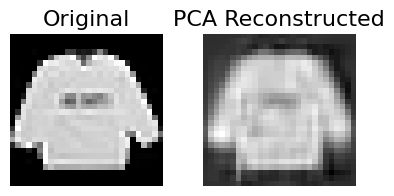

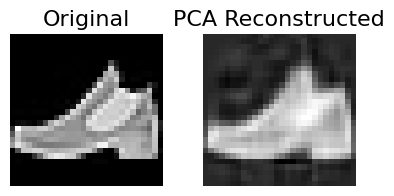

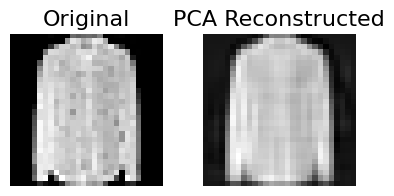

In [80]:
X_train_reconstructed = pca.inverse_transform(X_train_pca)
X_train_reconstructed = X_train_reconstructed.reshape(-1, 28, 28)

print(X_train.shape)
print(X_train_reconstructed.shape)

X_train_reshaped = X_train.to_numpy().reshape(-1, 28, 28)

def show_original_and_reconstructed(index):
    plt.figure(figsize=(4, 2))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_reshaped[index], cmap='gray')
    plt.title('Original', fontsize=16)
    plt.axis('off')
    
    # Reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_reconstructed[index], cmap='gray')
    plt.title('PCA Reconstructed', fontsize=16)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the comparison for a few examples
for i in range(3):
    show_original_and_reconstructed(i)

### Visualize the principal components

We can try to visualize the first few principal components here to get some idea, although it may not be very recognizable.

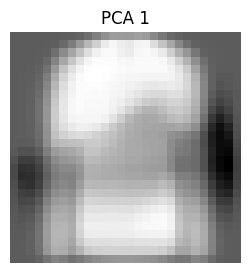

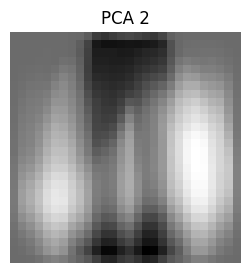

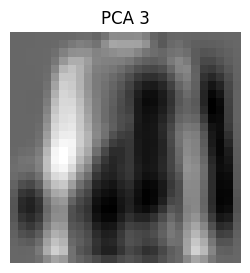

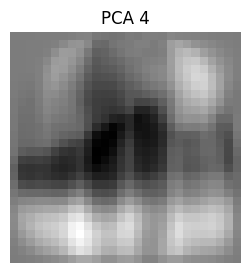

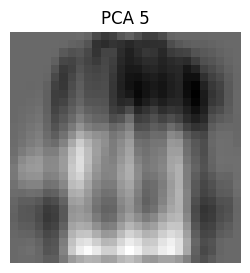

In [115]:
# Visualize the principal component
def plot_component(component, index):
    component = component.reshape(28, 28, 1)
    # normalize to [1, 1] range
    component = (component - component.min()) / (component.max() - component.min())    
    plt.figure(figsize=(3, 3))
    plt.imshow(component, interpolation='nearest', cmap='gray')
    plt.title(f'PCA {index+1}')
    plt.axis('off')
    plt.show()

# Show the first few principal components
for i in range(5):
    plot_component(pca.components_[i], i)

### Visualize the Clustering Results

Visualize the clusters with only 2 principal components involved.

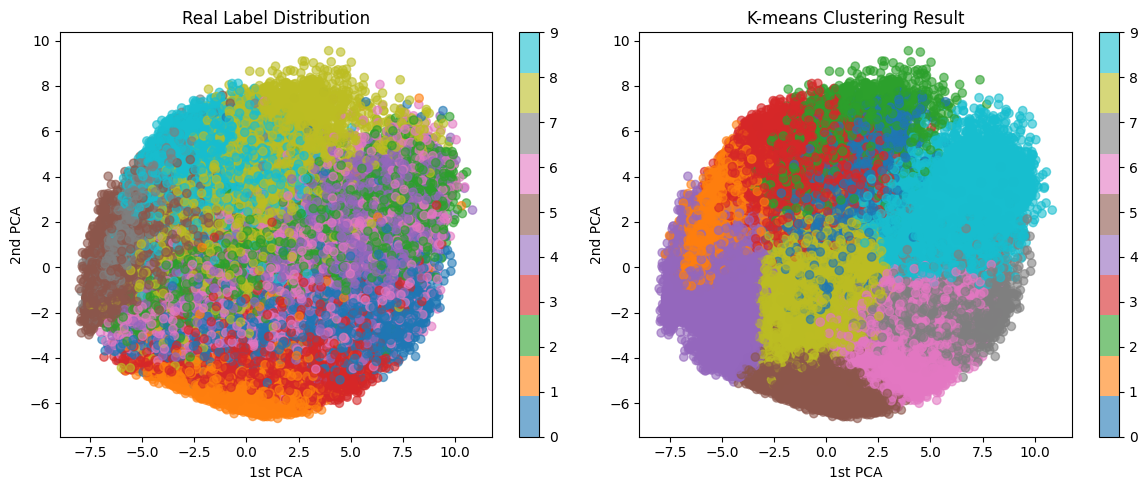

In [82]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_normalized)

plt.figure(figsize=(12, 5))

# Left: coloring with real labels
plt.subplot(1, 2, 1)
scatter1 = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_train, 
                      cmap='tab10', alpha=0.6)
plt.colorbar(scatter1)
plt.title('Real Label Distribution')
plt.xlabel('1st PCA')
plt.ylabel('2nd PCA')

# Right: coloring with clustered labels
plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=train_clusters, 
                      cmap='tab10', alpha=0.6)
plt.colorbar(scatter2)
plt.title('K-means Clustering Result')
plt.xlabel('1st PCA')
plt.ylabel('2nd PCA')

plt.tight_layout()
plt.show()

With the first 2 principal components, only 46.7% (0.29011353 + 0.17727668) of the variance is explained.

So it is understandable that the above visulization shows similar distribution patterns of the clusters, but not exactly match, and there are also some clusters mixed with each other.


## Analyze the real label distribution in each cluster


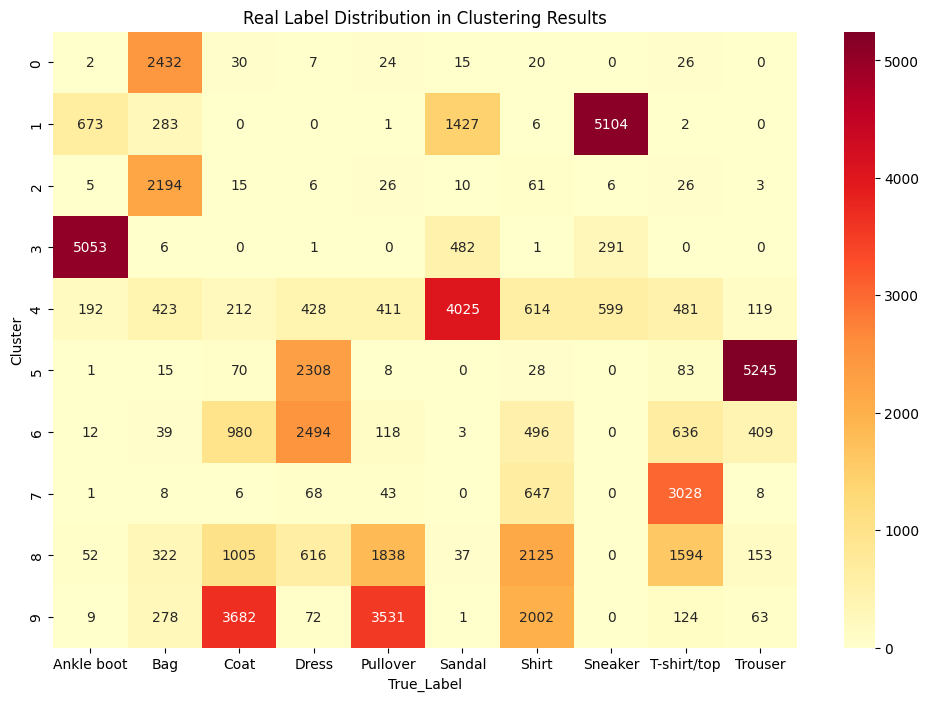

In [86]:
cluster_label_distribution = pd.DataFrame({
    'Cluster': train_clusters,
    'True_Label': [label_names[l] for l in y_train]
})

cluster_distribution = pd.crosstab(
    cluster_label_distribution['Cluster'], 
    cluster_label_distribution['True_Label']
)

# Display heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_distribution, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Real Label Distribution in Clustering Results')
plt.show()

## Supervised Learning

### 1. Logistic Regression

In [91]:
# Normalize
X_test_normalized = X_test / 255.0    # (10000, 784)

log_reg = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial', n_jobs=-1)

# Train the model
log_reg.fit(X_train_normalized, y_train)

# Predict
y_pred = log_reg.predict(X_test_normalized)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression on Fashion-MNIST Accuracy: {accuracy:.4f}")

c:\Users\chenr.000\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression on Fashion-MNIST Accuracy: 0.8526


### 2. SVM

Since SVM is very computation heavy, we will first use only 10% samples of the training data for first round training, and hyper-parameter tuning.

In [ ]:
# We can use only part of the data for training, since SVM is very costy
subset_size = 6000  # Use 10% percent of the training data

X_train_subset = X_train_normalized[:subset_size]
y_train_subset = y_train[:subset_size]

# Create the SVM model with default parameters
svm_clf = SVC()
# Train the model
svm_clf.fit(X_train_subset, y_train_subset)

# Predict on test data set
y_pred = svm_clf.predict(X_test_normalized)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM on Fashion-MNIST Accuracy: {accuracy:.4f}")

SVM on Fashion-MNIST Accuracy: 0.8485


### Hyper-parameter tuning for SVM

In [ ]:
param_dist = {
    'C': np.logspace(-2, 3, 15),
    'gamma': np.logspace(-5, 0, 15)
}

# Search for hyper-parameters
random_search = RandomizedSearchCV(
    svm_clf, param_distributions=param_dist, 
    n_iter=20, scoring='accuracy', cv=3, verbose=2, n_jobs=-1, random_state=42
)

# Train
random_search.fit(X_train_subset, y_train_subset)

# Best parameters
print(f"Best Parameters: {random_search.best_params_}")

# Use the best model for prediction
best_svm = random_search.best_estimator_
y_pred = best_svm.predict(X_test_normalized)

# Calculate accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Tuned SVM Accuracy: {acc:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'gamma': 0.037275937203149416, 'C': 84.83428982440725}
Tuned SVM Accuracy: 0.8677


### SVM: training with full data set, and fine tuned hyper parameters

In [ ]:
subset_size = len(X_train_normalized)
# We can use only part of the data for training, since SVM is very costy
# subset_size = 6000  # Use 10% percent of the training data

X_train_subset = X_train_normalized[:subset_size]
y_train_subset = y_train[:subset_size]

# Create the SVM model with the best hyper-parameters we found above
svm_clf = SVC(C=random_search.best_estimator_.get_params()['C'], gamma=random_search.best_estimator_.get_params()['gamma'])
# Train the model
svm_clf.fit(X_train_subset, y_train_subset)

# Predict on test data set
y_pred = svm_clf.predict(X_test_normalized)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM on Fashion-MNIST Accuracy: {accuracy:.4f}")

SVM on Fashion-MNIST Accuracy: 0.9136


### 3. Random Forest

In [ ]:
subset_size = 10000
X_train_subset = X_train_normalized[:subset_size]
y_train_subset = y_train[:subset_size]

# Create the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)

# Train the model
rf_clf.fit(X_train_subset, y_train_subset)

# Predict on test data set
y_pred = rf_clf.predict(X_test_normalized)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest on Fashion-MNIST Accuracy: {accuracy:.4f}")

Random Forest on Fashion-MNIST Accuracy: 0.8528


## Discussion and Conclusions

In this project we've explored a few models for image recognition.

1. On Unsupervised Learning, we used `PCA` for dimension reduction. We found that with 100 principal components, the explained variance ratio reaches `91%`, which means the dimension reduction is quite effective with this approach.

Then we reconstructed a few images from the PCA compressed data, by comparing the original images and the reconstructed images, we can understand by intuition how PCA helps with dimension reduction.

We also tried to visualize the first few principal components, but the images are not quite recognizable.

2. Then we used `K-Means` to cluster the data. The overall accuracy is at `58.97%`. With `K-Means` the accuracy for `Bag` is at 95%, which is quite good. But `Pullover` tends to be misclassified as `Bag`. In general, `K-Means` performance is not quite good.

3. Next we explored a few Supervised Learning models.
   - `Logistic Regression` achieved `85%` accuracy.
   - `Random Forest` achieved `85%` accuracy.
   - `SVM` achieved `84.5%` accuracy with default parameters (using only 10% of the training data), then with hyper-parameter tuning, we achieved `86.7%` accuracy. Later, we increased the training data set to use full data, and achieved `91%` accuracy.

4. In general we found that Supervised Learning models performs much better than the Unsupervised Learning model `K-Means` clustering. This may due to the fact that `K-Means` simply clusters data based on Euclidean distance, and can not capture advanced features of the image data, such as shape, texture, angle of the image, etc. While on Supervised Learning models side, `Logistic Regression` learns a linear decision boundary and can identify important pixel regions, and `SVM` uses kernel methods to learn complex decision boundaries, both can be more effective than `K-Means` clustering.

5. Limitations. In the Fashion MNIST data set, we achieved fairly good results with simple Supervised Learning models, this is because Fashion MNIST is still a relatively simple image recognition data set. With more complex data sets, such as `CIFAR-10`, which contains colorful images, with different backgrounds and other unrelated objects in the image, the supervised learning methods may not work well. We will need to deep learning or other more advanced models for it.